In [11]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

# install the alibi explainer first then import
from alibi.explainers import CEM # Following https://github.com/SeldonIO/alibi

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  2.11.0
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)


10000

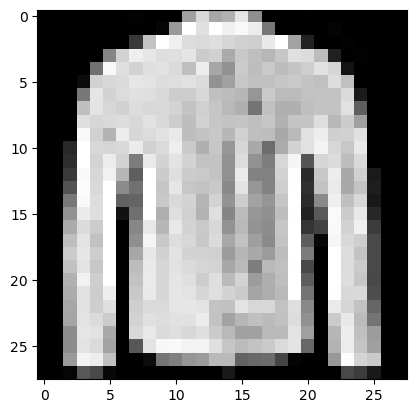

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[50]);len(x_test)

In [3]:
from keras.utils import to_categorical
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [14]:
# Load model
model = load_model('tf_fmnist_cnn_v2.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1]),x_test.shape

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.9157


(None, (10000, 28, 28, 1))

In [15]:
# Contrastive explanations parameters

mode = 'PP'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_test.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 100  # nb of iterations per value of c
feature_range = (x_test.min(),x_test.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative, 
                  # so positive/negative perturbations imply adding/removing features

In [16]:
# save model weights
cc_weight = model.get_weights()

(9,
 array([[7.7083797e-08, 1.1663006e-07, 4.4667234e-09, 1.0255393e-07,
         6.5380874e-08, 3.9138878e-05, 1.8612271e-08, 1.1448195e-03,
         3.0662795e-09, 9.9881566e-01]], dtype=float32))

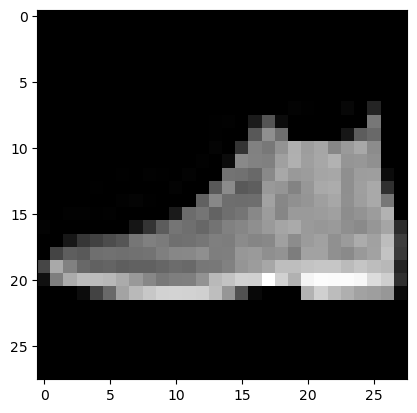

In [25]:
# An input sample and its predication by the model
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
plt.imshow(X.reshape(28, 28));
feature_range = (x_test.min(),x_test.max())
model.predict(X, verbose = 0).argmax(), model.predict(X, verbose = 0)

In [30]:
# Define auto-encoder
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [31]:
# Train the auto encoder
ae = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=5, validation_data=(x_test, x_test), verbose=0)
ae.save('tf_fmnist_cnn_v2_ae.h5', save_format='h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 1)         145       
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                             

In [ ]:
ae = load_model('tf_fmnist_cnn_v2_ae.h5')

Original input predicted class  9
Purturbed input predicted class  9


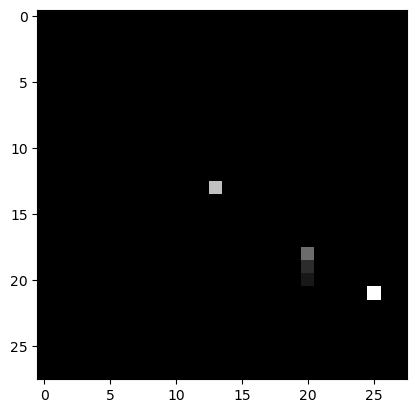

In [26]:
# Pertinent positive explanations
cem = CEM(model, 'PP', (1,28,28,1), kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=1000, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)#
X = X.reshape(1,28,28,1)
explanation = cem.explain(X)
X = explanation.PP.reshape(28,28)
print("Original input predicted class ", model.predict(x_test[idx].reshape((1,) + x_test[idx].shape).reshape(1,28,28,1)).argmax())
print("Purturbed input predicted class ",model.predict(X.reshape(1,28,28,1)).argmax())
plt.imshow(X)

Original input predicted class  9
Purturbed input predicted class  7


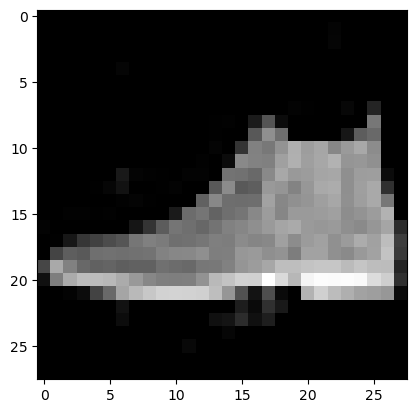

In [28]:
# Pertinent negative explanations
cem = CEM(model, 'PN', (1,28,28,1), kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=1000, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)#
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
X = X.reshape(1,28,28,1)
explanation = cem.explain(X)
X = explanation.PN.reshape(28,28)
print("Original input predicted class ", model.predict(x_test[idx].reshape((1,) + x_test[idx].shape).reshape(1,28,28,1)).argmax())
print("Purturbed input predicted class ",model.predict(X.reshape(1,28,28,1)).argmax())
plt.imshow(X)

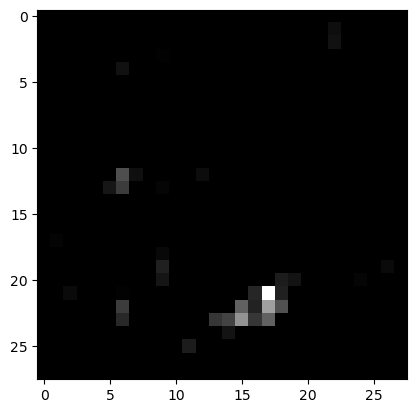

In [29]:
# Pertinent negative added perturbation visualization
x1 = x_test[idx].reshape((1,) + x_test[idx].shape)
X = X.reshape(1,28,28,1)
plt.imshow(X.reshape(28,28)  -  x1.reshape(28,28))

In [32]:
test_images = x_test
test_labels = y_test

In [34]:
# sub-sampling from test samples
NumSamplePerClass = 25
test_labels_new = []
test_images_new = []
l = {}
for i in range(len(test_labels[0])):
    l[i] = 0
for i in range(len(test_labels)):
    b = np.argmax(test_labels[i])
    if l[b]<NumSamplePerClass:
        test_images_new.append(test_images[i])
        test_labels_new.append(test_labels[i])
        l[b] = l[b] + 1
test_images_new = np.array(test_images_new)
test_labels_new = np.array(test_labels_new)
len(test_labels_new)

250

In [35]:
# Initialize empty lists for storing patterns
list1 = []
listx = []

In [37]:
cem = CEM(model, 'PP', X.shape , kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=1000, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

for i in range(len(test_labels_new)):
#     print(i)
    if model.predict(test_images_new[i].reshape(X.shape)).argmax()==test_labels_new[i].argmax():
#         print(i)
        a = test_images_new[i].reshape(X.shape)
        explanation = cem.explain(a)
        
        if explanation.PP is not None:
            print("Found")
            
            X = explanation.PP.reshape(X.shape)
        
            m = model.predict(a.reshape(X.shape)).tolist()[0]
            b = m.index(max(m))
            
            c = max(m)
            
            d = X
            
            n = model.predict(X).tolist()[0]
            e = n.index(max(n))
            o = max(n)
            n.remove(o)
            f = o - max(n)
            
            list1.append([b,c,d,f])
            listx.append(d)

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [38]:
# Save patterns
np.save("patterns_fmnist_cnn.npy", listx)